# PyTorch Workflow

Example of end-to-end PyTorch workflow.

In [3]:
import torch
from torch import nn ## contains all of PyTorch's basic building blocks for graphs. nn = neural network.

import matplotlib.pyplot as plt

torch.__version__

'2.4.0+cu121'

## Data

Preparing and loading data. Machine learning is a game of two parts:
1. Get data into a numerical representation
2. Build a model to learn patterns in that numerical representation.

To showcase this, let's create some *known* data using the linear regression formula.

In [4]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [5]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets

**One of the most important concepts in machine learning** is creating a training and test set (and when required, a validation set). Ecah split of the dataset serves a specific purpose:

| Split | Purpose | Amount of total data | Occurence |
|-------|---------|----------------------|-----------|
| Training set | The model learns from this data | ~60-80% | Always |
| Validation set | The model gets tuned on this data | ~10-20% | Often but not always |
| Testing set | The model is evaluated on this data | ~10-20% | Always |

In [10]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [36]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    """
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize=(10,7))
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    plt.scatter(test_data, test_labels, c="g", s=4, label="Test data")

    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    plt.legend(prop={"size": 14})

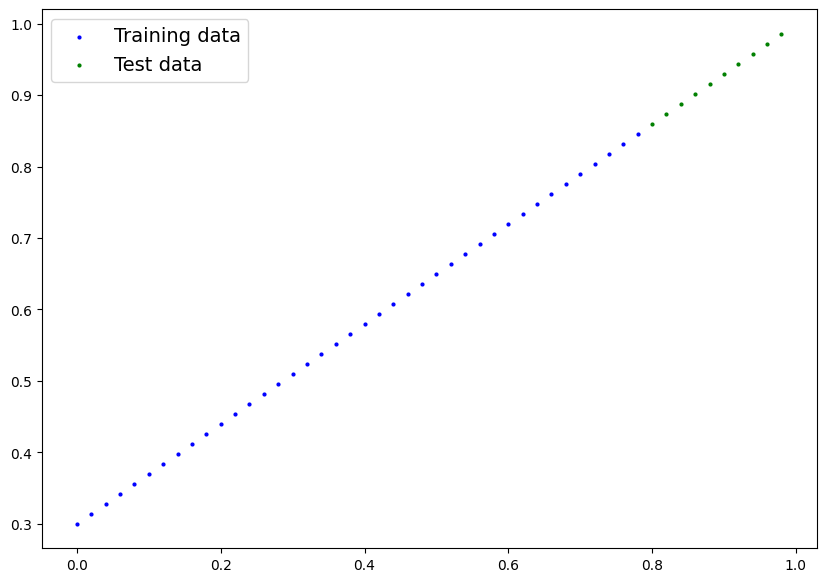

In [14]:
plot_predictions()

## Build

Giving shape to the model. This model does the following:

- Start with random values (weight & bias)
- Look at training data and adjust the random values to better represent (or get closer to) the ideal values.

It does this through two main algorithms:
1. Gradient descent: [https://www.youtube.com/watch?v=IHZwWFHWa-w](https://www.youtube.com/watch?v=IHZwWFHWa-w)
2. Backpropagation: [https://www.youtube.com/watch?v=Ilg3gGewQ5U](https://www.youtube.com/watch?v=Ilg3gGewQ5U)

In [15]:
class LinearRegressionModel(nn.Module): # almost everything in PyTorch inherits from nn.Module
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

    def forward(self, x: torch.Tensor) -> torch.Tensor: # should be overriden by every subclass
        return self.weights * x + self.bias # linear regression formula

### Model building essentials

[PyTorch Cheat Sheet](https://pytorch.org/tutorials/beginner/ptcheat.html)

- `torch.nn`, contains all of the buildings for computational graphs.
- `torch.nn.Parameter`, what parameters should our model try and learn, often a PyTorch layer from torch.
- `torch.nn.Module`, the base class for all neural network modules, every subclass should override `Module::forward`.
- `torch.optim`, where the PyTorch optimizers of PyTorch live in.
- `torch.utils.data.Dataset`, represents a map betweekn key (label) and sample (features) pairs of data.
- `torch.utils.data.DataLoader`, creates a Python iterable over a torch Dataset, allowing to iterate over the data.

In [209]:
model_0 = LinearRegressionModel()

print(list(model_0.parameters()))
model_0.state_dict()

[Parameter containing:
tensor([0.3923], requires_grad=True), Parameter containing:
tensor([-0.2236], requires_grad=True)]


OrderedDict([('weights', tensor([0.3923])), ('bias', tensor([-0.2236]))])

### Making predictions

When we pass data through the model, it's going to run throughout the `forward` method.

OrderedDict([('weights', tensor([-0.4542])), ('bias', tensor([-1.1170]))])

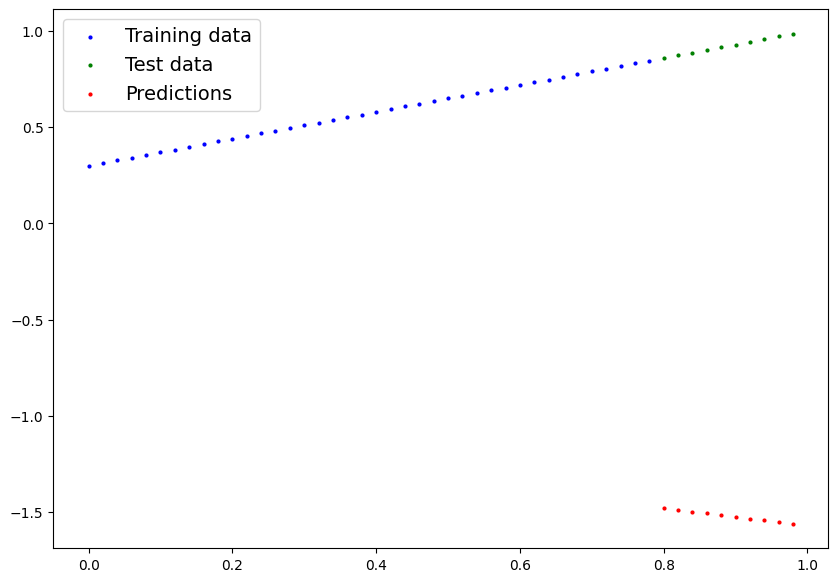

In [280]:
torch.manual_seed(110)
model_1 = LinearRegressionModel()

with torch.inference_mode(): # disables some of the PyTorch optimizations like grad_fn (see: https://x.com/PyTorch/status/1437838231505096708)
    y_preds = model_1(X_test)

plot_predictions(predictions=y_preds)
model_1.state_dict()

## Training

The whole idea of training is for a model to move from some *unknown* parameters (these may be random) to some *known* parameters. In other words, to move from a poor representation of the data into a proper one.


### Requirements

- **Loss function**, a function to measure how wrong the model's predictions are to the ideal outputs. Lower is better.
- **Optimizer**, takes into account the loss of a model and adjusts the model's parameters (e.g. the weight and bias). It does require:
  - `params`, the model parameters to optimize, for example `model_0.parameters()`
  - `lr`(learning rate), a hyperparameter that defines how big/small the optimizer changes the parameters with each step. A small `lr` results in small changes, while a larger one results in larger changes.

And specifically for PyTorch:
- A training loop
- A testing loop

> Note: Loss function may also be called cost function or criterion in different areas.

In [281]:
# 1. Set-up a loss function
loss_fn = nn.L1Loss() # MAE - mean absolute error

# 2. Set-up an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01) # stochastic gradient descent

> **Q**: Which loss function and optimizer should be used?

> **A**: This is problem specific. The experience will give an idea of what does work and what doesn't with each particular problem set. For example. For a regression problem (like this one), a loss function like `nn.L1Loss` and an optimizer like `optim.SGD` will suffice. But for a classification problem like identifying the animal in a photo it's probably better a loss function like `nn.BCELoss` (Binary Cross Entropy). 

### Training loop

0. Loop through the data.
1. Forward pass to make predictions on data, also called forward propagation.
2. Calculate the loss, comparing forward pass predictions to ground truth labels.
3. Optimize zero grad.
4. Loss backward, move backwards through the network to calculate the gradients of each of the parameters of the model with respect to the loss (**backpropagation**).
5. Optimizer step, uses the optimizer to adjust the model's parameters to try and improve the loss (**gradient descent**).

In [282]:
# 3. Build a training loop
print(f"{model_1.state_dict()}\n")
torch.manual_seed(2)

epochs = 1000 # each epoch is a loop through the data. This is a hyperparameter as we are manually setting it

epoch_count = []
loss_values = []
test_loss_values = []

# 3.0 Loop through the data
for epoch in range(epochs):
    model_1.train() # sets all parameters that require gradients to require gradients
    # 3.1 Forward pass
    y_pred = model_1(X_train)
    # 3.2 Calculate the loss
    loss = loss_fn(y_pred, y_train)
    # 3.3 Optimizer zero grad
    optimizer.zero_grad() # resets the step so it doesn't accumulate in each epoch
    # 3.4 Perform backpropagation 
    loss.backward()
    # 3.5 Step the optimizer
    optimizer.step()

    # Testing
    model_1.eval() # turns off gradient tracking and some other background PyTorch actions
    with torch.inference_mode():
        # 1. Do the forward pass
        test_pred = model_1(X_test)
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)
    if not epoch % 100:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)

OrderedDict([('weights', tensor([-0.4542])), ('bias', tensor([-1.1170]))])



Epoch      | Loss                      | Test                      |
0          | 1.867121934890747         | 2.4307327270507812        |
100        | 0.7150226831436157        | 1.0836336612701416        |
200        | 0.0873887911438942        | 0.21259889006614685       |
300        | 0.05284073203802109       | 0.12300467491149902       |
400        | 0.018498273566365242      | 0.042339909821748734      |
500        | 0.007012301590293646      | 0.0025923550128936768     |
600        | 0.007012301590293646      | 0.0025923550128936768     |
700        | 0.007012301590293646      | 0.0025923550128936768     |
800        | 0.007012301590293646      | 0.0025923550128936768     |
900        | 0.007012301590293646      | 0.0025923550128936768     |


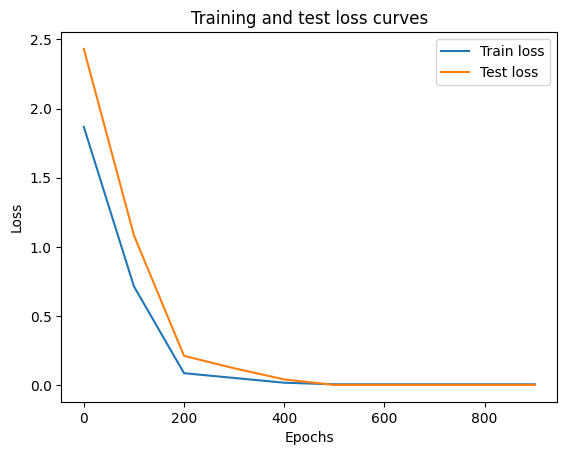

In [283]:
model_1.eval()

print(f"{'Epoch':<10} | {'Loss':<25} | {'Test':<25} |")
for e, l, t in zip(epoch_count, loss_values, test_loss_values):
    print(f"{e:<10} | {l:<25} | {t:<25} |")

with torch.inference_mode():
    plt.plot(epoch_count, loss_values, label="Train loss")
    plt.plot(epoch_count, test_loss_values, label="Test loss")
    plt.title("Training and test loss curves")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()

## Inference

Making predictions and evaluating the model.

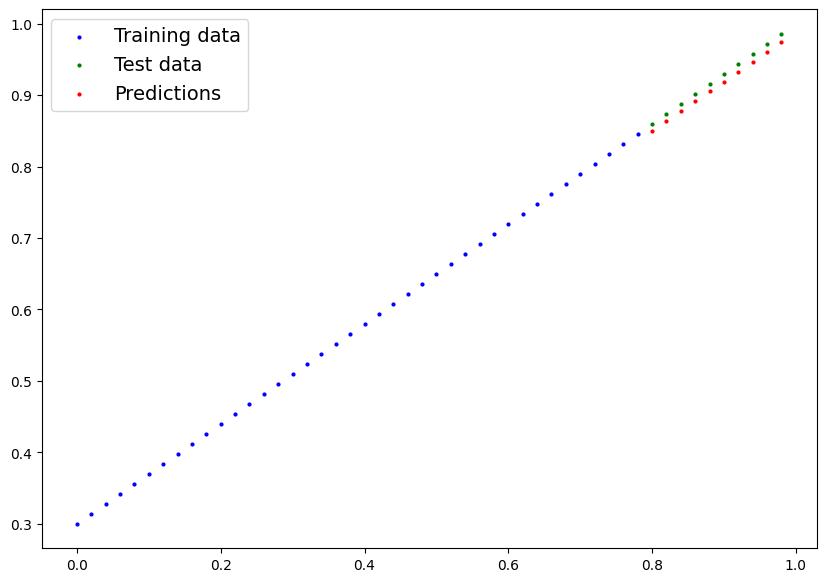

In [270]:
with torch.inference_mode():
    y_preds_new = model_1(X_test)

plot_predictions(predictions=y_preds_new)

## Reusing

Saving and reloading the model.

## Closing

Putting it all together.